# Kidney Stone Detection


## Importing Libraries


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from skimage.feature import hog 
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix

## Preparing Training Data


In [2]:
folder_path = "./dataset/train/"
filenames = []
categories = []

for category in os.listdir(folder_path):
    category_path = os.path.join(folder_path, category)
    
    if os.path.isdir(category_path):
        for filename in os.listdir(category_path):
            filenames.append(os.path.join(category, filename))
            categories.append(category)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [3]:
df.head()

,filename,category
0,Normal\Normal- (1).jpg,Normal
1,Normal\Normal- (10).jpg,Normal
2,Normal\Normal- (100).jpg,Normal
3,Normal\Normal- (1000).jpg,Normal
4,Normal\Normal- (101).jpg,Normal


In [6]:
df.tail()

,filename,category
2995,Stone\Stone- (995).jpg,Stone
2996,Stone\Stone- (996).jpg,Stone
2997,Stone\Stone- (997).jpg,Stone
2998,Stone\Stone- (998).jpg,Stone
2999,Stone\Stone- (999).jpg,Stone


<Axes: xlabel='category'>

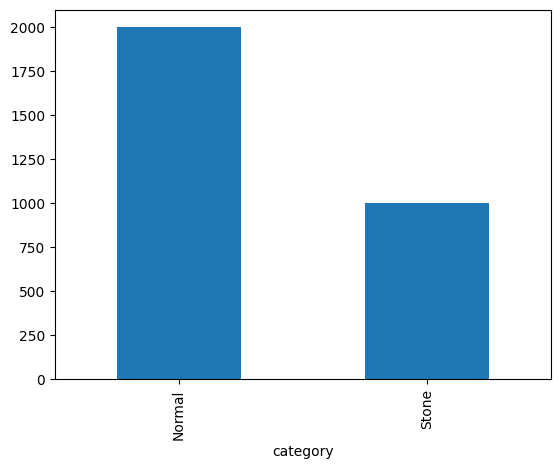

In [7]:
df['category'].value_counts().plot.bar()

## Visualizing Data


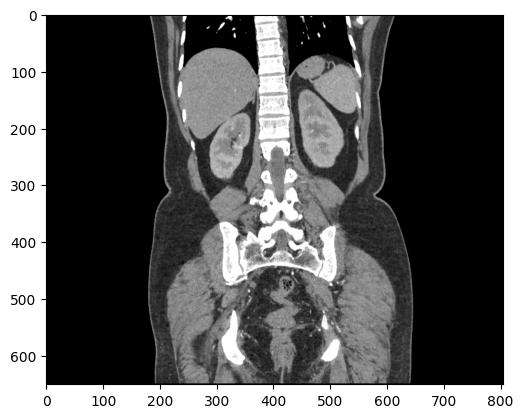

In [9]:
sample = random.choice(filenames)
image = load_img("./dataset/train/"+sample)
plt.imshow(image)

# CNN(Convolutional Neural Network)


## Building CNN Model


In [10]:
model = Sequential()

#Adding convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

#Adding a second convolutional layer
model.add(Conv2D(64, (3, 3) , activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Flatten())  # this converts our feature maps to 1D feature vectors
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2)) # as we have binary class i.e stone and normal so value is 2
model.add(Activation('sigmoid')) #sigmoid for binary class classification

c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    10,616,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,637,506 (40.58 MB)

 Trainable params: 10,637,058 (40.58 MB)

 Non-trainable params: 448 (1.75 KB)

### Call Backs


#### Early Stop

To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased


In [12]:
earlystop = EarlyStopping(patience=2)

#### Learning Rate Reduction

We will reduce the learning rate when then accuracy not increase for 2 steps


In [13]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [14]:
callbacks = [earlystop, learning_rate_reduction]

### Preparing Data


In [15]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<Axes: xlabel='category'>

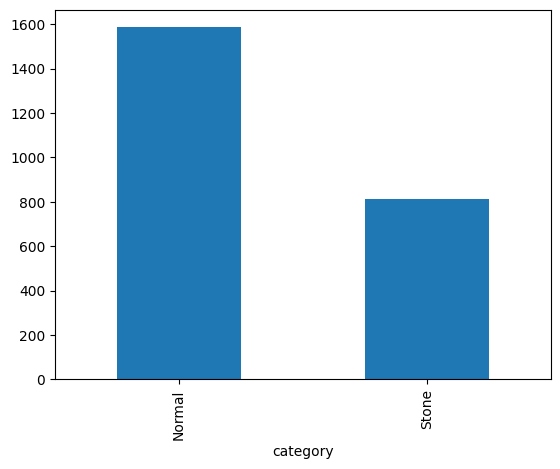

In [16]:
train_df['category'].value_counts().plot.bar()

<Axes: xlabel='category'>

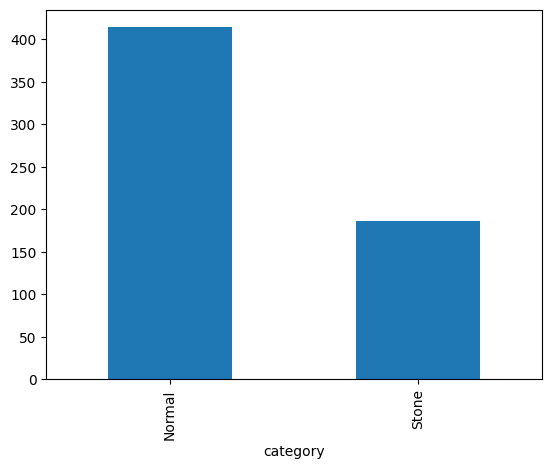

In [17]:
validate_df['category'].value_counts().plot.bar()

### Train and Validation generator


In [18]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

validation_datagen = ImageDataGenerator(rescale=1./255)

In [19]:
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "./dataset/train/", 
    x_col='filename',
    y_col='category',
    target_size=(150,150),
    class_mode='categorical',
    batch_size=15
)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./dataset/train/", 
    x_col='filename',
    y_col='category',
    target_size=(150,150),
    class_mode='categorical',
    batch_size=15
)

Found 2400 validated image filenames belonging to 2 classes.
Found 600 validated image filenames belonging to 2 classes.


### Visualizing the output of data gen


In [20]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "./dataset/train/", 
    x_col='filename',
    y_col='category',
    target_size=(150,150),
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


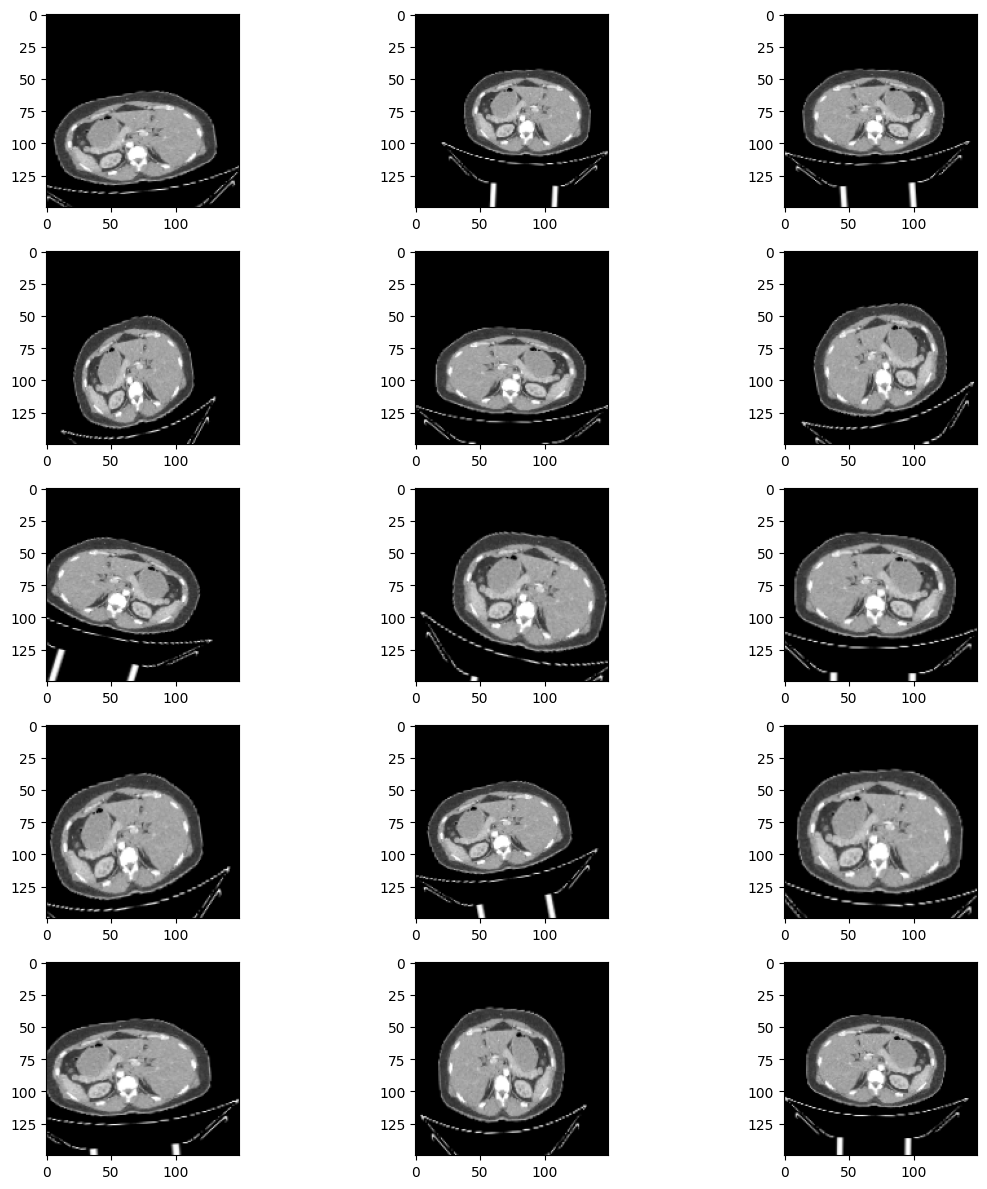

In [21]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

### Fitting the Model


In [22]:
# Compiling the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [35]:
history = model.fit(
    train_generator, 
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validate_df.shape[0]//15,
    steps_per_epoch=train_df.shape[0]//15,
    callbacks=callbacks
)

Epoch 1/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 133s 828ms/step - accuracy: 0.8836 - loss: 0.2962 - val_accuracy: 0.8700 - val_loss: 0.4969 - learning_rate: 0.0010
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 551us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/10


c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\callbacks\early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\callbacks\callback_list.py:151: UserWarning: Learning rate reduction is conditioned on metric `val_accuracy` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


160/160 ━━━━━━━━━━━━━━━━━━━━ 130s 813ms/step - accuracy: 0.8878 - loss: 0.2735 - val_accuracy: 0.7883 - val_loss: 0.6955 - learning_rate: 0.0010
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 705ms/step - accuracy: 0.9128 - loss: 0.2411
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
160/160 ━━━━━━━━━━━━━━━━━━━━ 121s 752ms/step - accuracy: 0.9127 - loss: 0.2411 - val_accuracy: 0.7983 - val_loss: 0.5193 - learning_rate: 0.0010
Epoch 6/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 7/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 125s 780ms/step - accuracy: 0.9094 - loss: 0.2151 - val_accuracy: 0.8183 - val_loss: 0.6562 - learning_rate: 5.0000e-04
Epoch 8/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 0s 197us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 5.0000e-04
Epoch 9/10
160/160

### Visualizing the Training history


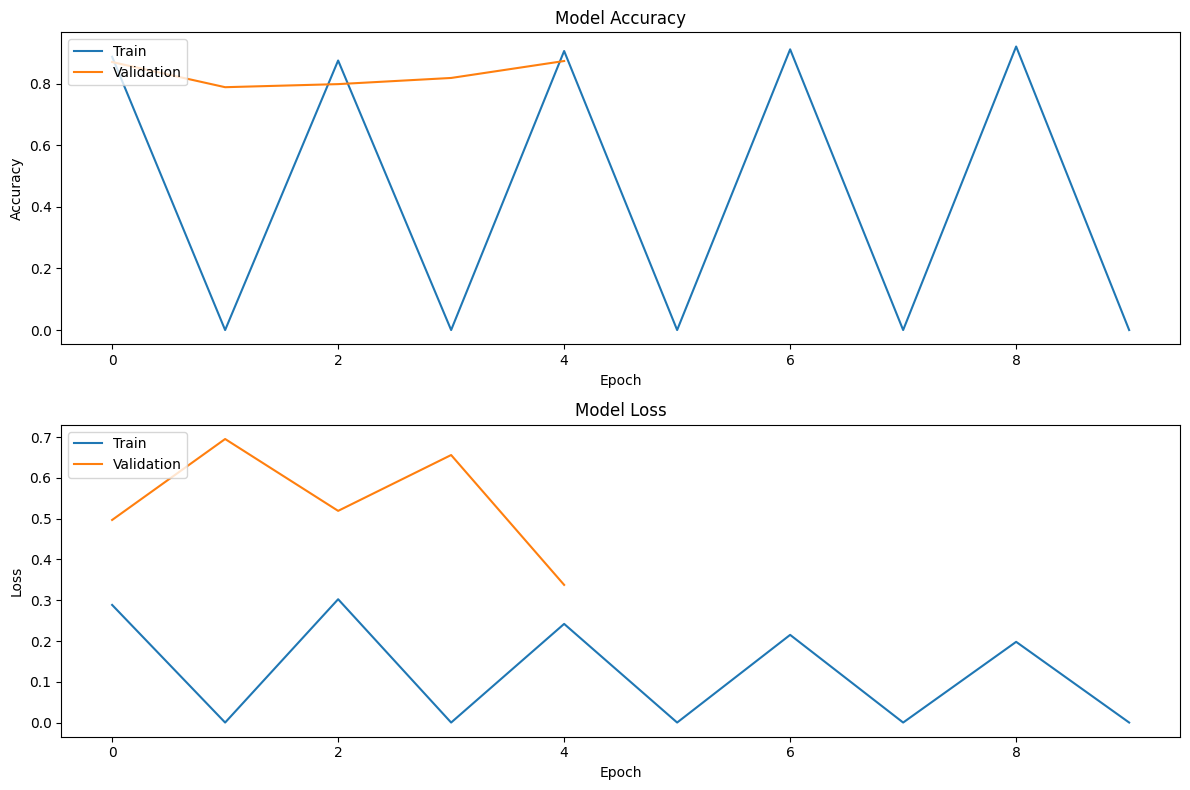

In [36]:
# Plotting the training history
plt.figure(figsize=(12, 8)) 

# Plot training & validation accuracy values
plt.subplot(2, 1, 1)  # 2 rows, 1 column, first subplot
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(2, 1, 2)  # 2 rows, 1 column, second subplot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

### Saving the CNN Model


In [37]:
# Saving the Model
model.save('kidney_stone_detection_model.h5')

### Testing Data


In [38]:
test_folder_path = "./dataset/test"
test_filenames = []
test_categories = []

for category in os.listdir(test_folder_path):
    test_category_path = os.path.join(test_folder_path, category)
    
    if os.path.isdir(test_category_path):
        for filename in os.listdir(test_category_path):
            test_filenames.append(os.path.join(category, filename))
            test_categories.append(category)

test_df = pd.DataFrame({
    'filename': test_filenames,
    'category': test_categories
})

In [39]:
test_gen = ImageDataGenerator(rescale=1./255)

test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "./dataset/test/", 
    x_col='filename',
    y_col='category',
    target_size=(150,150),
    class_mode='categorical',
    batch_size=15,
    shuffle=False
)

Found 900 validated image filenames belonging to 2 classes.


### Predictions


In [40]:
steps = int(np.ceil(test_df.shape[0] / 15))

predict = model.predict(test_generator, steps=steps)

c:\Users\Hp\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


60/60 ━━━━━━━━━━━━━━━━━━━━ 15s 250ms/step


In [41]:
test_df['predicted category'] = np.argmax(predict, axis=-1)

In [42]:
test_df['predicted category'] = test_df['predicted category'].replace({ 1: 'Stone', 0: 'Normal' })

In [43]:
test_df.head()

,filename,category,predicted category
0,Normal\Normal- (1001).jpg,Normal,Normal
1,Normal\Normal- (1002).jpg,Normal,Normal
2,Normal\Normal- (1003).jpg,Normal,Normal
3,Normal\Normal- (1004).jpg,Normal,Normal
4,Normal\Normal- (1005).jpg,Normal,Normal


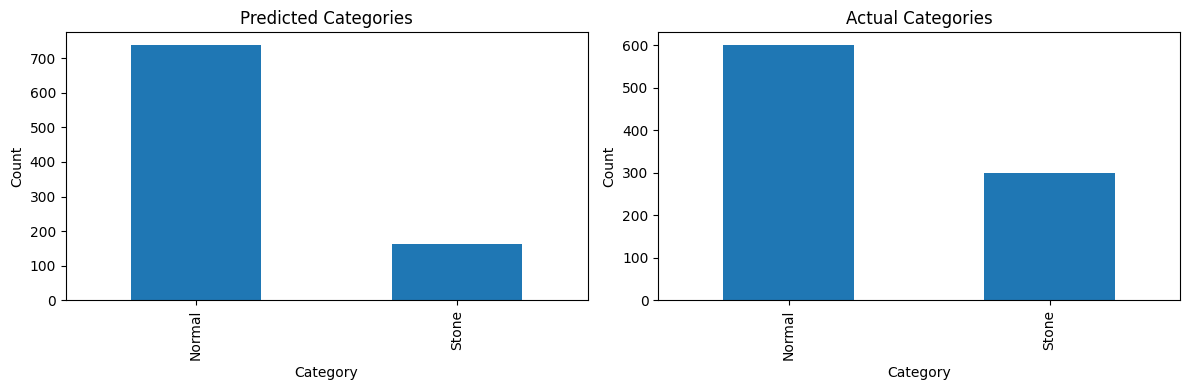

In [44]:
plt.figure(figsize=(12, 4))

# Plot the first bar plot (predicted category)
plt.subplot(1, 2, 1)
test_df['predicted category'].value_counts().plot.bar()
plt.title('Predicted Categories')
plt.xlabel('Category')
plt.ylabel('Count')

# Plot the second bar plot (actual category)
plt.subplot(1, 2, 2)
test_df['category'].value_counts().plot.bar()
plt.title('Actual Categories')
plt.xlabel('Category')
plt.ylabel('Count')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

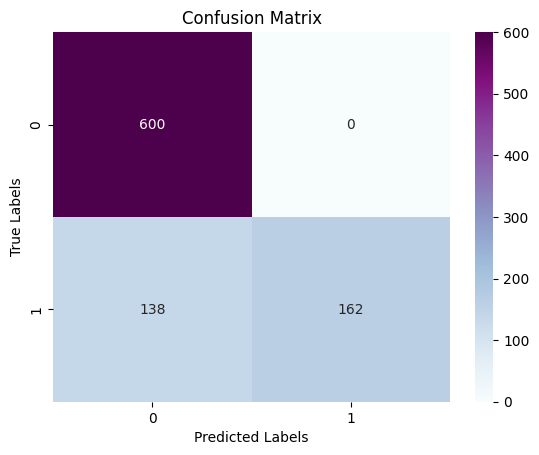

In [45]:
cm = confusion_matrix(test_df['category'], test_df['predicted category'])

sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu')

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.show()

The results is baised toward normal as we have more Normal Images


In [46]:
model.evaluate(test_generator)

60/60 ━━━━━━━━━━━━━━━━━━━━ 14s 225ms/step - accuracy: 0.9753 - loss: 0.0611


[0.4241655170917511, 0.846666693687439]